In [309]:
!pip install -q fastplot
!pip install -q imbalanced-learn
!pip install -q xgboost

In [310]:
import pandas as pd
import fastplot
%matplotlib inline
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import seaborn as sns
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import random

## Dataset

### Loading

In [311]:
df_nvd_v3 = pd.read_pickle('datasets/epss_v3.pkl')
df_nvd_v3_highest = pd.read_pickle('datasets/epss_v3_highest.pkl')
with open('datasets/cve_info.csv', 'r') as f:
    df_cve_info = pd.read_csv(f)
df_cve_info['published'] = pd.to_datetime(df_cve_info['published'])
current_cve = df_cve_info[df_cve_info['published'] >= '2023-03-07']['id'].values
df_nvd_v3_c = df_nvd_v3[df_nvd_v3['cve'].isin(current_cve)]
df_nvd_v3_c_highest = df_nvd_v3_c[df_nvd_v3_c['cve'].isin(df_nvd_v3_highest['cve'].unique())]

### Filter 60 days and discard already high CVEs

In [312]:
INTERVAL = 60
pd_interval = df_nvd_v3_c.iloc[0]['date'] + pd.Timedelta(days=INTERVAL)
df_interval = df_nvd_v3_c[df_nvd_v3_c['date'] < pd_interval]

df_interval_highest = df_nvd_v3_c_highest[df_nvd_v3_c_highest['date'] < pd_interval]
highest_cve_interval = set(df_interval_highest.groupby('cve').filter(lambda e: (e['epss'] > 0.7).any())['cve'])
df_interval = df_interval[~df_interval['cve'].isin(highest_cve_interval)]

### Remove 'rejected' CVEs

In [313]:
rejected_cve = df_cve_info[df_cve_info['vulnStatus'] == 'Rejected']['id'].values
df_interval = df_interval[~df_interval['cve'].isin(rejected_cve)]

In [314]:
features_columns = ['cve',
                    '#days_grow', 
                    '#days_drop', 
                    'epss_grow_sum', 
                    'epss_drop_sum', 
                    'max_epss', 
                    '#days_to_max', 
                    'std_dev',
                    'max_delta_epss']
df_features = pd.DataFrame(columns=features_columns)
df_features['cve'] = df_interval['cve'].unique()

## Features

### Number of days with delta-EPSS >(<) 0 and relative cumulative EPSS

In [315]:
def compute_consecutive_days_feature(df):
    delta_up = 0
    delta_down = 0
    days_up = 0
    days_down = 0
    sorted_dates = sorted(df['date'].unique())
    for date, epss in zip(sorted_dates[1:], df['epss'].iloc[1:]):
        try:
            prev_epss = float(df.loc[df['date'] == date - pd.Timedelta(days=1), 'epss'].values[0])
            if epss > prev_epss:
                days_up += 1
                delta_up += float((epss - prev_epss))
            elif epss < prev_epss:
                days_down += 1
                delta_down += float((epss - prev_epss))
            prev_epss = epss
        except:
            break
    cve = df['cve'].unique()[0]
    df_features.loc[df_features['cve'] == cve, features_columns[1]] = days_up
    df_features.loc[df_features['cve'] == cve, features_columns[2]] = days_down
    df_features.loc[df_features['cve'] == cve, features_columns[3]] = round(delta_up, 3)
    df_features.loc[df_features['cve'] == cve, features_columns[4]] = round(delta_down, 3)

### Maximum EPSS

In [316]:
def compute_max_epss_reached(df):
    cve = df['cve'].unique()[0]
    df_features.loc[df_features['cve'] == cve, features_columns[5]] = df['epss'].max()

### Days to reach maximum EPSS

In [317]:
def compute_days_to_reach_max_epss(df):
    cve = df['cve'].unique()[0]
    indices_of_max = [i for i, v in enumerate(df['epss'].values) if v == df['epss'].max()]
    df_features.loc[df_features['cve'] == cve, features_columns[6]] = indices_of_max[0] if indices_of_max else np.nan

### Standard deviation

In [318]:
def compute_standard_deviation(df):
    cve = df['cve'].unique()[0]
    std_dev = df['epss'].std()
    if np.isnan(std_dev):
        std_dev = 0
    df_features.loc[df_features['cve'] == cve, features_columns[7]] = std_dev

### Maximum delta EPSS

In [319]:
def compute_max_delta_epss(df):
    cve = df['cve'].unique()[0]
    max_peak = df.loc[df['epss'].diff() > 0].max()
    if np.isnan(max_peak['epss']):
        df_features.loc[df_features['cve'] == cve, features_columns[8]] = 0
        return
    date_before_max = max_peak['date'] - pd.Timedelta(days=1)
    try:
        epss_before_max = df[df['date'] == date_before_max]['epss'].values[0]
    except:
        epss_before_max = max_peak['epss']
    df_features.loc[df_features['cve'] == cve, features_columns[8]] = max_peak['epss'] - epss_before_max

## Model

### Features creation

In [320]:
df_interval.groupby('cve').apply(compute_consecutive_days_feature)
df_interval.groupby('cve').apply(compute_max_epss_reached)
df_interval.groupby('cve').apply(compute_days_to_reach_max_epss)
df_interval.groupby('cve').apply(compute_standard_deviation)
df_interval.groupby('cve').apply(compute_max_delta_epss)
highest_cves = set(df_nvd_v3_c_highest['cve'].unique())
df_features['has_reached_threshold'] = df_interval.groupby('cve').apply(lambda e: True if e.name in highest_cves else False).values

In [321]:
cols_to_convert = features_columns[1:]
df_features[cols_to_convert] = df_features[cols_to_convert].apply(pd.to_numeric, errors='coerce')

### Training and results

In [322]:
def print_results(model, predictions):
    y_scores = model.predict_proba(X_test)[:, 1]
    n_decimal = 4
    print(f"{'Accuracy'.ljust(20)} {str(round(accuracy_score(y_test, predictions), n_decimal)).rjust(10)}")
    print(f"{'Precision'.ljust(20)} {str(round(precision_score(y_test, predictions), n_decimal)).rjust(10)}")
    print(f"{'Recall'.ljust(20)} {str(round(recall_score(y_test, predictions), n_decimal)).rjust(10)}")
    print(f"{'F1-score'.ljust(20)} {str(round(f1_score(y_test, predictions), n_decimal)).rjust(10)}")
    print(f"{'AUC-ROC'.ljust(20)} {str(round(roc_auc_score(y_test, predictions), n_decimal)).rjust(10)}")
    print()

    conf_matrix = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix, annot=True, square=True, cmap='rocket_r', norm=LogNorm(), fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(model.__class__.__name__)
    plt.show()

In [323]:
X = df_features.drop(['has_reached_threshold', 'cve'], axis=1)
y = df_features['has_reached_threshold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ne = 10000
rs = random.randint(0, 1000)
print("seed:", rs)

seed: 309


In [303]:
rf_params = {
    'n_estimators': [5000, 10000],
    'max_depth': [None, 10, 20]
}

model_rf = GridSearchCV(RandomForestClassifier(random_state=rs, class_weight='balanced'), param_grid=rf_params, cv=5, scoring='f1')
model_rf.fit(X_train, y_train)
model = model_rf.best_estimator_
predictions_rf = model.predict(X_test)
print_results(model, predictions_rf)

KeyboardInterrupt: 

Accuracy                 0.6019
Precision                0.0131
Recall                   0.7143
F1-score                 0.0257
AUC-ROC                  0.6577



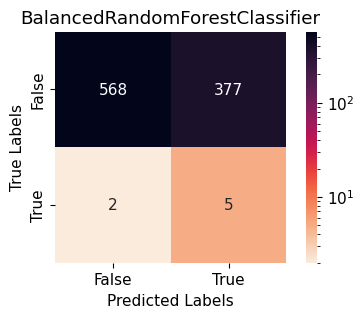

In [296]:
model_brf = BalancedRandomForestClassifier(n_estimators=rs, random_state=ne, sampling_strategy='auto', replacement=False, bootstrap=True)
model_brf.fit(X_train, y_train)
predictions_brf = model_brf.predict(X_test)
print_results(model_brf, predictions_brf)

In [324]:
xgb_params = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(200, 600, 100)
}
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model_xgb = GridSearchCV(xgb.XGBClassifier(scale_pos_weight=ratio, random_state=rs), param_grid=xgb_params, cv=5, scoring='f1')
model_xgb.fit(X_train, y_train)
xgb_best = model_xgb.best_estimator_
predictions_xgb = xgb_best.predict(X_test)
print_results(xgb_best, predictions_xgb)

KeyboardInterrupt: 

## Features distribution

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

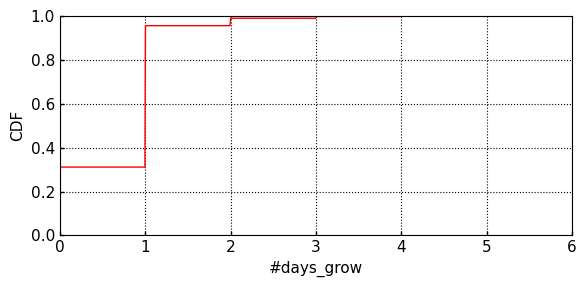

In [326]:
fastplot.plot(df_features[features_columns[1]].values, None, mode='CDF', grid=True, 
              xlabel=features_columns[1], figsize=(6, 3))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

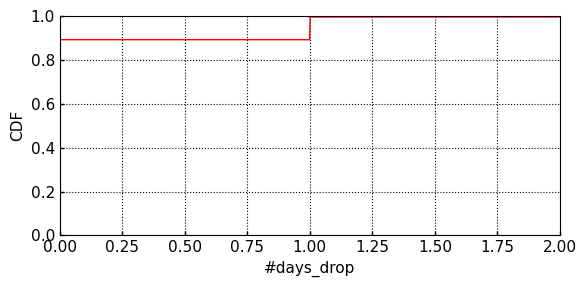

In [327]:
fastplot.plot(df_features[features_columns[2]].values, None, mode='CDF', grid=True, 
              xlabel=features_columns[2], figsize=(6, 3))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

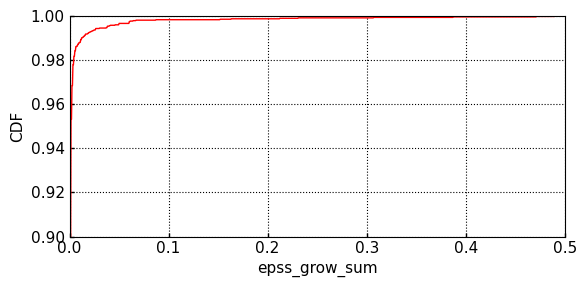

In [329]:
fastplot.plot(df_features[features_columns[3]].values, None, mode='CDF', grid=True, 
              xlabel=features_columns[3], figsize=(6, 3), ylim=(0.9,1.0))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

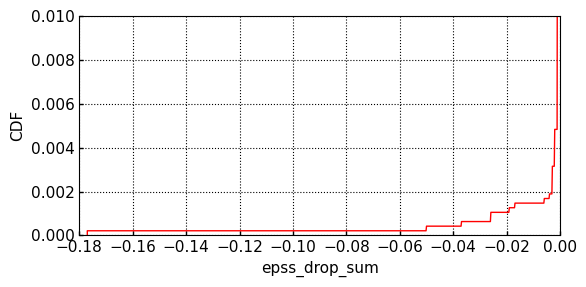

In [340]:
fastplot.plot(df_features[features_columns[4]].values, None, mode='CDF', grid=True, 
              xlabel=features_columns[4], figsize=(6, 3), ylim=(0.0, 0.01))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

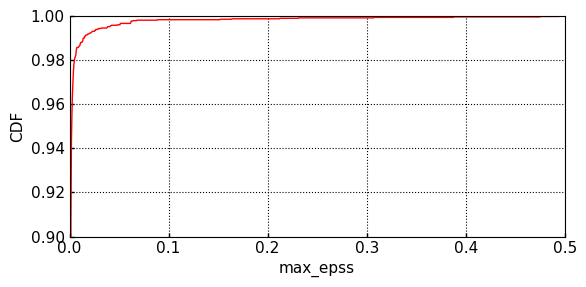

In [332]:
fastplot.plot(df_features[features_columns[5]].values, None, mode='CDF', grid=True, 
              xlabel=features_columns[5], figsize=(6, 3), ylim=(0.9, 1.0))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

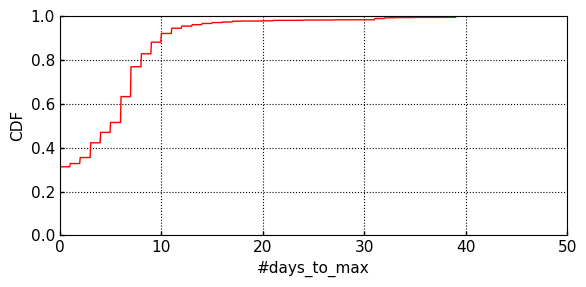

In [333]:
fastplot.plot(df_features[features_columns[6]].values, None, mode='CDF', grid=True, 
              xlabel=features_columns[6], figsize=(6, 3))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

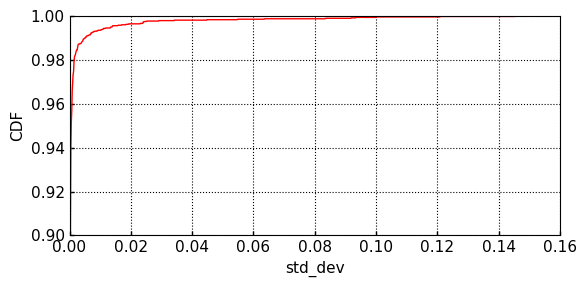

In [335]:
fastplot.plot(df_features[features_columns[7]].values, None, mode='CDF', grid=True, 
              xlabel=features_columns[7], figsize=(6, 3), ylim=(0.9, 1.0))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

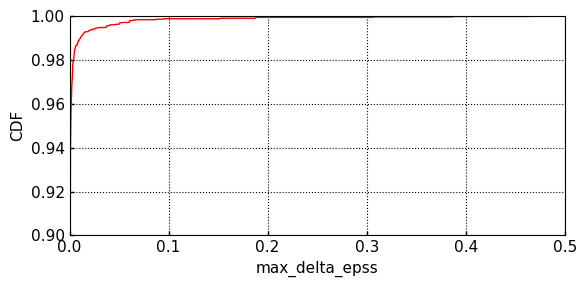

In [337]:
fastplot.plot(df_features[features_columns[8]].values, None, mode='CDF', grid=True, 
              xlabel=features_columns[8], figsize=(6, 3), ylim=(0.9, 1.0))